In [74]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn import tree
from sklearn.ensemble import RandomForestRegressor


from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

from sklearn import linear_model
from sklearn.linear_model import Ridge


random_param_test = 3
random_param_cv = 13

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score # MSE and R squared



# Import data

In [75]:
df_full = pd.read_csv('student-por.csv', sep = ';')

display(df_full.head())

print("Shape is", df_full.shape )

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


Shape is (649, 33)


In [76]:
# Drop columns 'G1' and 'G2'. These are test scores from other periods. 
# The school requests a model that does not use these test scores to predict the 'G3' exam score.

df_full = df_full.drop(['G1','G2'], axis=1)

print("Shape is", df_full.shape )

Shape is (649, 31)


# Feature engineering, step 1: Bin rare categories.

We consider any category that contains less than 5% of students a rare category.
We will now find the rare categories and group the data with related categories (i.e. binning) to remove any rare categories.

In [77]:
# For each column, print the percentage of students who fall into each category:
for col in df_full.columns:
    print(col)
    print(df_full[col].value_counts()/649*100)
    print(' ')    
    print(' ')

school
GP    65.177196
MS    34.822804
Name: school, dtype: float64
 
 
sex
F    59.013867
M    40.986133
Name: sex, dtype: float64
 
 
age
17    27.580894
16    27.272727
18    21.571649
15    17.257319
19     4.930663
20     0.924499
21     0.308166
22     0.154083
Name: age, dtype: float64
 
 
address
U    69.645609
R    30.354391
Name: address, dtype: float64
 
 
famsize
GT3    70.416025
LE3    29.583975
Name: famsize, dtype: float64
 
 
Pstatus
T    87.673344
A    12.326656
Name: Pstatus, dtype: float64
 
 
Medu
2    28.659476
4    26.964561
1    22.033898
3    21.417565
0     0.924499
Name: Medu, dtype: float64
 
 
Fedu
2    32.203390
1    26.810478
3    20.184900
4    19.722650
0     1.078582
Name: Fedu, dtype: float64
 
 
Mjob
other       39.753467
services    20.955316
at_home     20.801233
teacher     11.093991
health       7.395994
Name: Mjob, dtype: float64
 
 
Fjob
other       56.548536
services    27.889060
at_home      6.471495
teacher      5.546995
health       3.543914

In [78]:
# age=19,20,21,22 are rare categories at 4.93 %, 0.92 %, 0.31 %, and 0.15 % representation, respectively.
# We will group them into a single age '19'.
# Define the function for binning:

def get_age(N):
    
    if N<19 :
        return N
            
    else:
        return 19
    
# Create a new feature 'age_bin' 
df_full['age_bin'] = df_full['age'].apply(get_age)


In [79]:
# Since Medu=0 is a rare category with 0.92 % representation, we will group it with the category '1'.
# Similarly for Fedu=0
# Define the function for binning:

def get_edu(N):
    
    if N<1 :
        return 1
            
    else:
        return N
    
# Create new features 'Medu_bin' and 'Fedu_bin' 

df_full['Medu_bin'] = df_full['Medu'].apply(get_edu)
df_full['Fedu_bin'] = df_full['Fedu'].apply(get_edu)


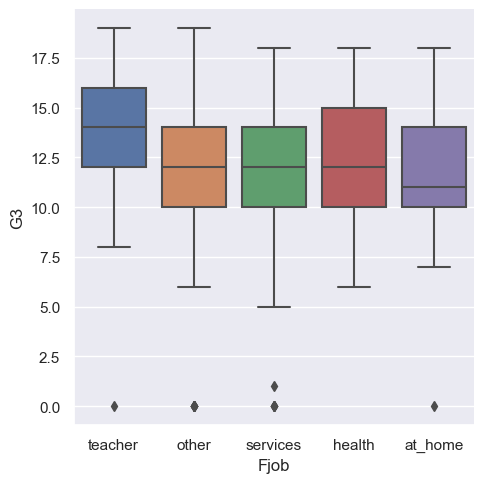

In [80]:
# Fjob = health is a rare category at 3.5% representation.
# From the following box plot, we see 'health' has a similar distribution as 'other', 
#    so we will group those categories together into the bin called 'other'.

sns.catplot(data=df_full, x="Fjob", y="G3", kind="box" )


def get_Fjob(N):
    
    if N=='health' :
        return 'other'
            
    else:
        return N
    
# Create a new feature 'Fjob_bin' 

df_full['Fjob_bin'] = df_full['Fjob'].apply(get_Fjob)



In [81]:
# traveltime = 4 is a rare category at 2.5% representation. 
# Combine traveltime = 3 and 4 to the category '3'.

def get_traveltime(N):
    
    if N>3 :
        return 3
            
    else:
        return N
    

# Create a new feature 'traveltime_bin' 

df_full['traveltime_bin'] = df_full['traveltime'].apply(get_traveltime)


In [82]:
# failures = 2,3 are a rare categories at 2.5% and 2.2% representation, respectively. 
# Combine failures = 1,2,3 to the category '1'.

def get_failures(N):
    
    if N>0 :
        return 1
            
    else:
        return N
    
# Create a new feature 'failures_bin' 

df_full['failures_bin'] = df_full['failures'].apply(get_failures)


In [83]:
# famrel = 1,2 are a rare categories at 4.5% and 3.5% representation, respectively. 
# Combine famrel = 1,2 into the category '2'.

def get_famrel(N):
    
    if N<3 :
        return 2
            
    else:
        return N
    
# Create a new feature 'famrel_bin' 

df_full['famrel_bin'] = df_full['famrel'].apply(get_famrel)


In [84]:
# Dalc = 4,5 are a rare categories at 2.6% representation each. 
# Combine Dalc = 4,5 into the category '4'.

def get_Dalc(N):
    
    if N>3 :
        return 4
            
    else:
        return N
    
# Create a new feature 'Dalc_bin' 

df_full['Dalc_bin'] = df_full['Dalc'].apply(get_Dalc)


In [85]:
# Lastly, we consider absences. 
# We see that mosts students have 0 absences. 

df_full['absences'].value_counts()

0     244
2     110
4      93
6      49
8      42
10     21
1      12
12     12
5      12
16     10
14      8
9       7
3       7
11      5
18      3
7       3
21      2
15      2
22      2
30      1
26      1
24      1
13      1
32      1
Name: absences, dtype: int64

In [86]:
# Since 244 students have 0 absences, we will choose to have 3 bins of size about 200.
# Define the function for binning:

def get_absences(N):
    
    if N == 0 :
        return 1
        
    elif N>0 and N<5 :
        return 2
    
    else:
        return 3
    
# Create a new feature 'absences_bin' that takes the three values:
# absences_bin = 1 if absences = 0
# absences_bin = 2 if absences = 1,2,3, or 4
# absences_bin = 3 if absences > 4

df_full['absences_bin'] = df_full['absences'].apply(get_absences)


# We see that the size of the bins are approximately 200

df_full['absences_bin'].value_counts()

1    244
2    222
3    183
Name: absences_bin, dtype: int64

In [87]:
# We have added 9 new binned features and are at a total of 40 columns.

df_full.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,G3,age_bin,Medu_bin,Fedu_bin,Fjob_bin,traveltime_bin,failures_bin,famrel_bin,Dalc_bin,absences_bin
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,11,18,4,4,teacher,2,0,4,1,2
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,11,17,1,1,other,1,0,5,1,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,12,15,1,1,other,1,0,4,2,3
3,GP,F,15,U,GT3,T,4,2,health,services,...,14,15,4,2,services,1,0,3,1,1
4,GP,F,16,U,GT3,T,3,3,other,other,...,13,16,3,3,other,1,0,4,1,1


# Feature engineering, step 2: add polynomial features.

The features 'freetime' and 'goout' should have a quadratic fit and not a linear fit. 

The reason behind this decision is that students who have very little free time (freetime = 1) score worse than students with some free time (freetime = 2). That is, 'G3' increases from freetime=1 to freetime=2. However, students with freetime > 2 see a monotonic decrease in their 'G3' score. This behavior can be modelled well by a quadratic fit. 

We demonstrate the behavior by showing the box plot for 'freetime' and 'goout'. We see that the distribution of 'goout' behaves similarly to 'freetime'.


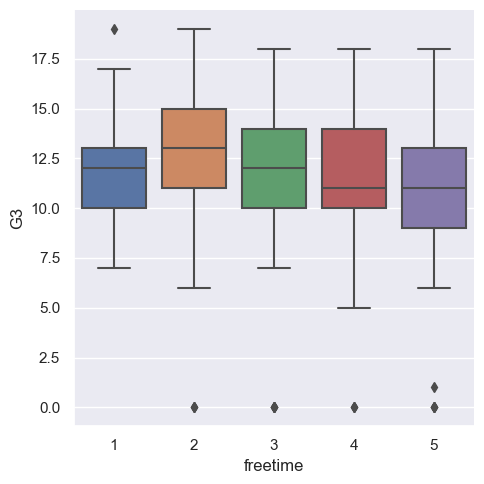

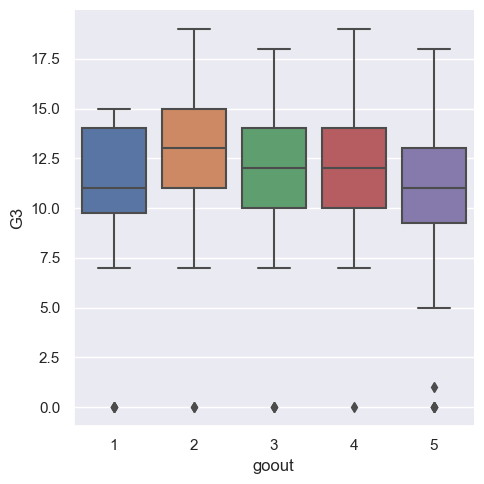

In [88]:
sns.catplot(data=df_full, x="freetime", y="G3", kind="box")

sns.catplot(data=df_full, x="goout", y="G3", kind="box")

In [89]:
# We now add those polynomial features 'freetime'^2 and 'goout'^2

df_full['freetime_squared'] = df_full['freetime']**2
df_full['goout_squared'] = df_full['goout']**2

# Adding these two columns brings us to 42 columns:
print("Shape is", df_full.shape )

Shape is (649, 42)


In [90]:
# Separate the binned and unbinned dataframes:

unbin_cols = ['age','Medu','Fedu','Fjob','traveltime','failures','famrel','Dalc','absences']

bin_cols = ['age_bin','Medu_bin','Fedu_bin','Fjob_bin','traveltime_bin','failures_bin','famrel_bin','Dalc_bin','absences_bin']

len(unbin_cols)

df_unbin = df_full.drop(bin_cols, axis=1).copy()
df_bin = df_full.drop(unbin_cols, axis=1).copy()



***

# Preprocessing: one-hot encode the categorical features


In [91]:
enc_unbin = OneHotEncoder(handle_unknown='ignore',drop='first')

# Choose the categorical columns:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols_unbin = [cname for cname in df_unbin.columns if df_unbin[cname].nunique() < 10 and 
                        df_unbin[cname].dtype == "object"]

print(categorical_cols_unbin)

print(len(categorical_cols_unbin))

# -----------------------------------

# Preprocessing: one-hot encode the categorical features
enc_bin = OneHotEncoder(handle_unknown='ignore',drop='first')

# Choose the categorical columns:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols_bin = [cname for cname in df_bin.columns if df_bin[cname].nunique() < 10 and 
                        df_bin[cname].dtype == "object"]

print(categorical_cols_bin)

print(len(categorical_cols_bin))

['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
17
['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'Fjob_bin']
17


In [92]:
# Extract the categorical_cols and apply one-hot

df_unbin_onehot = df_full[categorical_cols_unbin].copy()

enc_unbin.fit(df_unbin_onehot)



OneHotEncoder(drop='first', handle_unknown='ignore')

In [93]:
# Extract the categorical_cols and apply one-hot

df_bin_onehot = df_full[categorical_cols_bin].copy()

enc_bin.fit(df_bin_onehot)



OneHotEncoder(drop='first', handle_unknown='ignore')

In [94]:
df_unbin_onehot = pd.DataFrame(enc_unbin.transform(df_unbin_onehot).toarray())
df_bin_onehot = pd.DataFrame(enc_bin.transform(df_bin_onehot).toarray())

In [95]:
col_unbin_onehot = enc_unbin.get_feature_names_out()

df_unbin_onehot.columns = col_unbin_onehot

#display(df_unbin_onehot.head())

print("Shape is", df_unbin_onehot.shape )

# -----------------------------------

col_bin_onehot = enc_bin.get_feature_names_out()

df_bin_onehot.columns = col_bin_onehot

#display(df_bin_onehot.head())

print("Shape is", df_bin_onehot.shape )

Shape is (649, 26)
Shape is (649, 25)


In [96]:
# Now drop the categorical_cols and add in the onehot encoded:

df_unbin = df_unbin.drop(categorical_cols_unbin, axis=1).copy()

df_unbin = df_unbin.merge(df_unbin_onehot, how='left', left_index=True, right_index=True)



,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,17,1,1,1,2,0,5,3,3,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,15,1,1,1,2,0,4,3,2,2,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
3,15,4,2,1,3,0,3,2,2,1,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
4,16,3,3,1,2,0,4,3,2,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
5,16,4,3,1,2,0,5,4,2,1,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
6,16,2,2,1,2,0,4,4,4,1,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
7,17,4,4,2,2,0,4,1,4,1,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
8,15,3,2,1,2,0,4,2,2,1,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
9,15,3,4,1,2,0,5,5,1,1,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0


In [98]:
# Now drop the categorical_cols and add in the onehot encoded:

df_bin = df_bin.drop(categorical_cols_bin, axis=1).copy()

df_bin = df_bin.merge(df_bin_onehot, how='left', left_index=True, right_index=True)



,studytime,freetime,goout,Walc,health,G3,age_bin,Medu_bin,Fedu_bin,traveltime_bin,...,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,Fjob_bin_other,Fjob_bin_services,Fjob_bin_teacher
0,2,3,4,1,3,11,18,4,4,2,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,2,3,3,1,3,11,17,1,1,1,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,2,3,2,3,3,12,15,1,1,1,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
3,3,2,2,1,5,14,15,4,2,1,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,2,3,2,2,5,13,16,3,3,1,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
5,2,4,2,2,5,13,16,4,3,1,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
6,2,4,4,1,3,13,16,2,2,1,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
7,2,1,4,1,1,13,17,4,4,2,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
8,2,2,2,1,1,17,15,3,2,1,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
9,2,5,1,1,5,13,15,3,4,1,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0


# Exploratory data analysis: 
We have already performed the majority of our EDA in the file Misc/Exploratory.ipynb, wherein we use the pandas profiling package and seaborn plots to gain insight into the data.

As a result of that EDA, we remark that the feature 'failures' is a strong predictor for exam scores 'G3'. A student who has failed at least one course in the past is expected to perform worse than a student who has not failed any courses. 

We see the correlations below, and confirm that 'failures' has a high correlation with 'G3'.

In [101]:
corr_matrix_unbin = df_unbin.corr()

corr_matrix_unbin['G3']

age                 -0.106505
Medu                 0.240151
Fedu                 0.211800
traveltime          -0.127173
studytime            0.249789
failures            -0.393316
famrel               0.063361
freetime            -0.122705
goout               -0.087641
Dalc                -0.204719
Walc                -0.176619
health              -0.098851
absences            -0.091379
G3                   1.000000
freetime_squared    -0.139009
goout_squared       -0.116278
school_MS           -0.284294
sex_M               -0.129077
address_U            0.167637
famsize_LE3          0.045016
Pstatus_T           -0.000754
Mjob_health          0.101244
Mjob_other          -0.059251
Mjob_services        0.038447
Mjob_teacher         0.134910
Fjob_health          0.039142
Fjob_other          -0.005301
Fjob_services       -0.053204
Fjob_teacher         0.125916
reason_home          0.046537
reason_other        -0.132577
reason_reputation    0.170944
guardian_mother     -0.004415
guardian_o

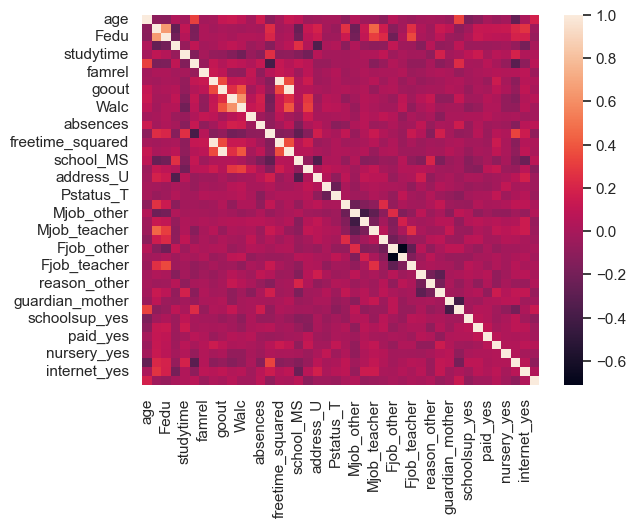

In [102]:
sns.heatmap(corr_matrix_unbin)
plt.show()

# Feature engineering, step 3: Dropping outliers.
A small number of students did not take exam 'G3' and thus scored a 0. A student may not take the exam for a number of reasons (poor health, family emergency, etc.).

We will consider the effect on our models of dropping the rows where G3=0.

In [106]:
#Remove the 15 students who did not take the G3 exam. This includes 15 students, or 2.3% of the total population.

df_out_bin = df_bin.loc[ df_bin['G3'] != 0 ]

display(df_out_bin.shape)

# -----------------------------------

df_out_unbin = df_unbin.loc[ df_unbin['G3'] != 0 ]

display(df_out_unbin.shape)



(634, 41)

(634, 42)

***

# Modeling: Linear Regression vs. Random Forest Regressor
We have 4 datasets: 
- __df_unbin__: Corresponding to the original unbinned data.
- __df_bin__: Corresponding to the binned data.
- __df_out_unbin__: Same as df_unbin except dropping the students who did not take the exam.
- __df_out_bin__: Same as df_bin except dropping the students who did not take the exam.

We will consider two models applied to the above data sets: 
- Linear Regression (with Lasso and Ridge regularization) 
- Random Forest Regression

We compare the performance of these models against the benchmarks:
- Bench 1: Predict every student scored the average score.
- Bench 2: Linear regression using one feature, 'failures'. 
    - We choose to use 'failures' because it is the feature that has the highest correlation with 'G3': correl = -0.39


In [107]:
for dataset in range(1,5):
    if dataset == 1:
        df = df_unbin
        print('Results for df_unbin:')
    elif dataset == 2:
        df = df_bin
        print('Results for df_bin:')
    elif dataset == 3:
        df = df_out_unbin
        print('Results for df_out_unbin:')
    else:
        df = df_out_bin
        print('Results for df_out_bin:')
    
    print(" ")

    # Separate target from predictors
    y = df.G3
    X = df.drop(['G3'], axis=1)
    
    # Divide data into training and test subsets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                    random_state=random_param_test)
    
    ## Bench 1: Predicting every student scored the average.
    def Average(lst):
        return sum(lst) / len(lst)

    avg = Average(y_train)
    #print("Average is %.2f" % avg)
    
    ones_len_test = [1]*len(y_test)
    y_pred_avg = [x * avg for x in ones_len_test]
    print("Bench 1, pred_avg")
    print("     MAE: %.2f" % mean_absolute_error(y_test, y_pred_avg) )
    print(" ")
    
    ## Bench 2: Linear regression using 'failures' or 'failures_bin'.
    model_LinReg_failures = linear_model.LinearRegression()
    cols_unbin = ['failures','G3']
    cols_bin = ['failures_bin','G3']    
    if dataset == 1:        
        df_failures = df[cols_unbin].copy()
    elif dataset == 2:      
        df_failures = df[cols_bin].copy()
    elif dataset == 3:        
        df_failures = df[cols_unbin].copy()
    else:        
        df_failures = df[cols_bin].copy()
    # Separate target from predictors
    y_failures = df_failures.G3
    X_failures = df_failures.drop(['G3'], axis=1)
    # Divide data into training and test subsets
    X_failures_train, X_failures_test, y_failures_train, y_failures_test = train_test_split(X_failures, y_failures, train_size=0.8, test_size=0.2,
                                                                    random_state=random_param_test)
    model_LinReg_failures.fit(X_failures_train, y_failures_train)
    # Make predictions using the testing set
    y_pred_failures = model_LinReg_failures.predict(X_failures_test)
    # The mean absolute error
    print("Bench 2, pred_failures")
    print("     MAE: %.2f" % mean_absolute_error(y_failures_test, y_pred_failures))
    print(" ")

    
    ## Model 1: Linear regression with all features
    model_LinReg = linear_model.LinearRegression()
    model_LinReg.fit(X_train, y_train)
    y_pred_LinReg = model_LinReg.predict(X_test)
    print("Model 1, lin reg")
    print("     MAE: %.2f" % mean_absolute_error(y_test, y_pred_LinReg) )
    print(" ")

    
    ## Model 1a: Linear regression with Lasso Regularization
    clf = linear_model.Lasso(alpha=.1)
    clf.fit(X_train, y_train)
    y_pred_Lasso = clf.predict(X_test)
    print("Model 1a, Lasso")
    print("     MAE: %.2f" % mean_absolute_error(y_test, y_pred_Lasso) )
    print(" ")
    
    
    ## Hyperparameter tuning for Lasso:
    
    # Divide data into training and test subsets
    X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2,
                                                                    random_state=random_param_test)
    # Set up grid for parameter
    exp = np.arange(1,100)
    lam = 10 * 0.9 ** exp

    # Instantiate MAE
    MAE = 10
    
    # Lasso regression grid search
    for lambda_j in lam:
        lin_Lasso_j = linear_model.Lasso(lambda_j)
        lin_Lasso_j.fit(X_train2, y_train2)
        y_val_pred_j = lin_Lasso_j.predict(X_valid)
        MAE_j = mean_absolute_error(y_valid, y_val_pred_j)
        if MAE_j < MAE:
            lin_Lasso = lin_Lasso_j
            MAE = MAE_j
            
    y_pred_Tuned_Lasso = lin_Lasso.predict(X_test)
    print("Model 1a tuned, Lasso")
    print("     MAE: %.2f" % mean_absolute_error(y_test, y_pred_Tuned_Lasso) )
    print("     a =  %.2f" % lin_Lasso.get_params()['alpha'])
    print(" ")
    
    ## Model 1b: Linear regression with Ridge Regularization
    clf2 = Ridge(alpha=1)
    clf2.fit(X_train, y_train)
    y_pred_Ridge = clf2.predict(X_test)
    print("Model 1b, Ridge")
    print("     MAE: %.2f" % mean_absolute_error(y_test, y_pred_Ridge) )
    print(" ")
    
    ## Hyperparameter tuning for Ridge:
    
    lambdas_Ridge = np.arange(1,100)
  
    # Instantiate MAE
    MAE = 10
    
    # Ridge regression for each regularization parameter in grid
    for lambda_j in lambdas_Ridge:
        lr_j = linear_model.Ridge(lambda_j)
        lr_j.fit(X_train2, y_train2)
        y_val_pred_j = lr_j.predict(X_valid)
        MAE_j = mean_absolute_error(y_valid, y_val_pred_j)
        if MAE_j < MAE:
            lr_Ridge = lr_j
            MAE = MAE_j
            
    y_pred_Tuned_Ridge = lr_Ridge.predict(X_test)
        #Consider hyperparam tuning using cross validation. Tuned Ridge is overfitting to X_valid.
             #By overfitting, we mean MAE of untuned Ridge < MAE of tuned Ridge.
    print("Model 1b tuned, Ridge")
    print("     MAE: %.2f" % mean_absolute_error(y_test, y_pred_Tuned_Ridge) )
    print("     a =  %.2f" % lr_Ridge.get_params()['alpha'])
    print(" ")
      
        
    ## Model 2: Random Forest Regressor
    model_Forest = RandomForestRegressor(random_state=0)
    model_Forest.fit(X_train, y_train)
    y_pred_Forest = model_Forest.predict(X_test)
    print("Model 2, forest")
    print("     MAE: %.2f" % mean_absolute_error(y_test, y_pred_Forest) )
    print(" ")
    
    
    print('-----------------------------------')
    print(" ")

Results for df_unbin:
 
Bench 1, pred_avg
     MAE: 2.29
 
Bench 2, pred_failures
     MAE: 2.17
 
Model 1, lin reg
     MAE: 1.90
 
Model 1a, Lasso
     MAE: 2.00
 
Model 1a tuned, Lasso
     MAE: 1.93
     a =  0.05
 
Model 1b, Ridge
     MAE: 1.90
 
Model 1b tuned, Ridge
     MAE: 1.93
     a =  37.00
 
Model 2, forest
     MAE: 1.89
 
-----------------------------------
 
Results for df_bin:
 
Bench 1, pred_avg
     MAE: 2.29
 
Bench 2, pred_failures
     MAE: 2.13
 
Model 1, lin reg
     MAE: 1.88
 
Model 1a, Lasso
     MAE: 1.94
 
Model 1a tuned, Lasso
     MAE: 1.90
     a =  0.06
 
Model 1b, Ridge
     MAE: 1.88
 
Model 1b tuned, Ridge
     MAE: 1.91
     a =  34.00
 
Model 2, forest
     MAE: 1.87
 
-----------------------------------
 
Results for df_out_unbin:
 
Bench 1, pred_avg
     MAE: 2.18
 
Bench 2, pred_failures
     MAE: 2.10
 
Model 1, lin reg
     MAE: 1.66
 
Model 1a, Lasso
     MAE: 1.81
 
Model 1a tuned, Lasso
     MAE: 1.69
     a =  0.02
 
Model 1b, Ridge
    